# Tarea Final del Curso de NLP: Clasificación de Emociones en Tweets

- Estudiante: Rodrigo Tenorio Ramirez
- Fecha: 25 de agosto de 2025

### Introducción
Este notebook presenta un estudio exploratorio de tres modelos de Procesamiento de Lenguaje Natural (NLP) aplicados a la tarea de clasificación de emociones en tweets en español. El objetivo es analizar y comparar el rendimiento de diferentes arquitecturas en el dataset EmoEvent, que contiene 8409 tweets anotados con una de las ocho categorías: anger, sadness, joy, disgust, fear, surprise y others.

Los modelos a explorar son:
- Una Red Neuronal Recurrente (LSTM), adaptada de un modelo de detección de sarcasmo.
- Un modelo BERT (BETO), realizando un fine-tuning sobre un modelo pre-entrenado en español.
- Un modelo T5 usando fine-tunning.

Se realizarán análisis de resultados por cada emoción y por cada evento mencionado en el dataset, incluyendo matrices de confusión y una discusión sobre los hallazgos.

### Legacy

Se añade algunas librerias especiales para hacer correr bert en tensorflow,T5 tendra que ser corrido en pytorch ya que no es posible correrlo de otra forma

In [1]:

# 1. Instalar la versión de Keras compatible
!pip install tf_keras -q
!pip install --upgrade transformers sentencepiece -q
# 2. Configurar la variable de entorno para forzar el uso de Keras 2
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow as tf
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
from transformers import BertTokenizer, TFBertForSequenceClassification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 92.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 26.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.


2025-08-28 10:08:25.501775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756375705.860091      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756375705.964634      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Carga y Exploración de Datos (EDA)
El primer paso es obtener los datos del repositorio de EmoEvent y realizar un análisis exploratorio para entender su estructura y distribución.
### 1.1. Carga de Datos
Los datos están divididos en tres archivos (entrenamiento, validación y prueba). Los cargaremos en DataFrames de Pandas.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# URLs de los datos crudos desde el repositorio de GitHub
train_url = 'https://raw.githubusercontent.com/fmplaza/EmoEvent/f55f01c78e77fb2c711b40f3ff6925f605bc5101/splits/es/train.tsv'
val_url = 'https://raw.githubusercontent.com/fmplaza/EmoEvent/f55f01c78e77fb2c711b40f3ff6925f605bc5101/splits/es/dev.tsv'
test_url = 'https://raw.githubusercontent.com/fmplaza/EmoEvent/f55f01c78e77fb2c711b40f3ff6925f605bc5101/splits/es/test.tsv'

# Cargar los datos especificando el separador de TABULADOR
column_names = ['id', 'event', 'tweet', 'offensive', 'emotion']
df_train = pd.read_csv(train_url, sep='\t', header=None, names=column_names, skiprows=[0])
df_val = pd.read_csv(val_url, sep='\t', header=None, names=column_names, skiprows=[0])
df_test = pd.read_csv(test_url, sep='\t', header=None, names=column_names, skiprows=[0])

print("Datos de entrenamiento cargados:", df_train.shape)
print("Datos de validación cargados:", df_val.shape)
print("Datos de prueba cargados:", df_test.shape)

print("\nPrimeras filas del dataset de entrenamiento:")
print(df_train.head())

Datos de entrenamiento cargados: (5723, 5)
Datos de validación cargados: (844, 5)
Datos de prueba cargados: (1656, 5)

Primeras filas del dataset de entrenamiento:
                                     id          event  \
0  a0c1a858-a9b8-4cb1-8a81-1602736ff5b8  GameOfThrones   
1  9b272817-a231-4f68-bdf4-3350d4919330      Venezuela   
2  4bd5b1e5-4b74-440a-82f4-c2567a241011      NotreDame   
3  0bb9d7c9-d781-4684-890e-a94bfb50acc0      NotreDame   
4  88749098-d539-4500-9209-0bbfae2b109c  GameOfThrones   

                                               tweet offensive  emotion  
0  La Gran Guerra de #JuegoDeTronos nos ha dejado...        NO   others  
1  El golpe de Estado en #Venezuela está más lejo...        NO   others  
2  No tengo una foto en la catedral de #NotreDame...        NO  sadness  
3  #NotreDame nunca llegue a visitar tan grandios...        NO  sadness  
4      A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos       OFF  sadness  


### 1.2. Análisis Exploratorio de Datos (EDA)
Ahora, analizaremos la distribución de las emociones y los eventos en el conjunto de entrenamiento para comprender mejor los datos.

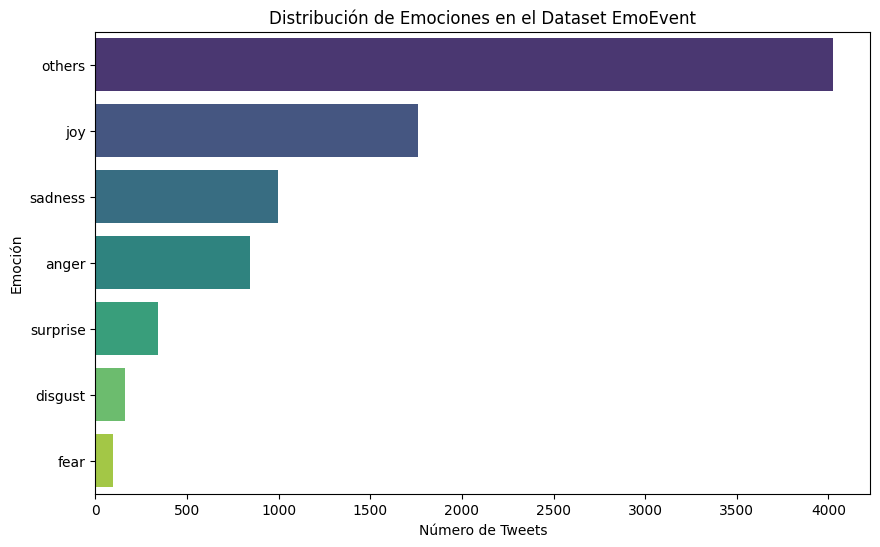

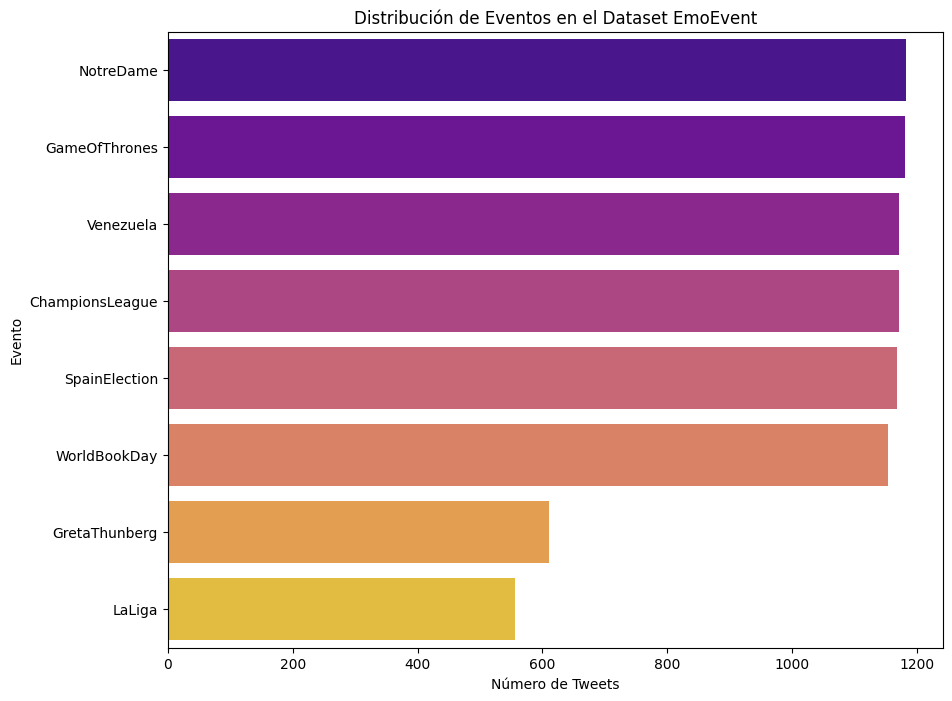

In [5]:

df_full = pd.concat([df_train, df_val, df_test], ignore_index=True)

# 1. Distribución de Emociones
plt.figure(figsize=(10, 6))
sns.countplot(y='emotion', data=df_full, order=df_full['emotion'].value_counts().index, palette='viridis')
plt.title('Distribución de Emociones en el Dataset EmoEvent')
plt.xlabel('Número de Tweets')
plt.ylabel('Emoción')
plt.show()

# 2. Distribución de Eventos
plt.figure(figsize=(10, 8))
sns.countplot(y='event', data=df_full, order=df_full['event'].value_counts().index, palette='plasma')
plt.title('Distribución de Eventos en el Dataset EmoEvent')
plt.xlabel('Número de Tweets')
plt.ylabel('Evento')
plt.show()


**Observaciones del EDA:**
*   **Emociones:** Existe un desbalance significativo entre las clases. La emoción `other` es la más frecuente, seguida por `joy` y `sadness`. Las emociones como `fear` y `disgust` tienen muy pocas muestras, lo que podría dificultar el entrenamiento y la evaluación de los modelos para estas categorías.
*   **Eventos:** Los tweets están distribuidos entre varios eventos, siendo `GameOfThrones`, `NotreDame` y `Venezuela` los más prominentes. El análisis por evento será clave para entender si los modelos generalizan bien o si su rendimiento depende del contexto temático.


## **2. Preprocesamiento de Texto**

Para preparar los datos para los modelos, realizaremos un preprocesamiento estándar que incluye la limpieza de texto y la codificación de las etiquetas.

In [6]:
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder

def preprocess_tweet(tweet):
    """
    Función para limpiar el texto de un tweet.
    - Elimina URLs
    - Elimina menciones de usuario y hashtags
    - Elimina caracteres no alfanuméricos
    - Convierte a minúsculas
    """
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#','', tweet)
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    tweet = tweet.lower()
    return tweet.strip()

# --- CORRECCIÓN AQUÍ ---
# Convertir toda la columna a string ANTES de aplicar la función de limpieza.
# Esto manejará cualquier valor NaN (float) que pueda haber.
df_train['clean_tweet'] = df_train['tweet'].astype(str).apply(preprocess_tweet)
df_val['clean_tweet'] = df_val['tweet'].astype(str).apply(preprocess_tweet)
df_test['clean_tweet'] = df_test['tweet'].astype(str).apply(preprocess_tweet)

# Codificar las etiquetas de texto a números
label_encoder = LabelEncoder()
df_train['emotion_encoded'] = label_encoder.fit_transform(df_train['emotion'])
df_val['emotion_encoded'] = label_encoder.transform(df_val['emotion'])
df_test['emotion_encoded'] = label_encoder.transform(df_test['emotion'])

# Mapeo de etiquetas para referencia futura
emotion_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print("Mapeo de etiquetas a números:", emotion_mapping)
print("\nEjemplo de tweet preprocesado:")
print("Original:", df_train['tweet'][0])
print("Limpio:", df_train['clean_tweet'][0])

Mapeo de etiquetas a números: {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'joy', 4: 'others', 5: 'sadness', 6: 'surprise'}

Ejemplo de tweet preprocesado:
Original: La Gran Guerra de #JuegoDeTronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas https://t.co/UE7lCgLSez https://t.co/OO3tjUR34c
Limpio: la gran guerra de juegodetronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas


## 3. Modelo 1: Red Neuronal Recurrente (LSTM)
Usaremos un  modelo LSTM hecho en tensorflow, no tiene muchas capas lo que hace que sea menos presiso pero más rapido en su entrenamiento, lo usaremos para que sea un multiclase de nuestras 7 emociones.


### 3.1. Tokenización y Padding
Primero, convertimos las secuencias de texto en secuencias de enteros y las rellenamos para que todas tengan la misma longitud.

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parámetros para la tokenización
vocab_size = 10000
max_length = 100
embedding_dim = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Preparar datos
X_train = df_train['clean_tweet'].values
y_train = df_train['emotion_encoded'].values
X_val = df_val['clean_tweet'].values
y_val = df_val['emotion_encoded'].values
X_test = df_test['clean_tweet'].values
y_test = df_test['emotion_encoded'].values

# Inicializar y ajustar el Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

# Convertir textos a secuencias y aplicar padding
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_val_padded = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding=padding_type, truncating=trunc_type)

### 3.2. Construcción y Entrenamiento del Modelo LSTM
Definimos la arquitectura del modelo. Lo principal es en la capa de salida: usamos 7 neuronas (una por emoción) y la función de activación softmax para clasificación multiclase. La función de pérdida será `sparse_categorical_crossentropy`.

In [8]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation='softmax') # 7 neuronas para 7 emociones
])

model_lstm.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_lstm.build(input_shape=(None, max_length))
model_lstm.summary()



I0000 00:00:1756375794.068390      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756375794.069154      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          41472     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 4

In [9]:
# Entrenar el modelo
history_lstm = model_lstm.fit(X_train_padded, y_train,
                              epochs=10,
                              validation_data=(X_val_padded, y_val),
                              verbose=2)

Epoch 1/10


I0000 00:00:1756375808.946676     119 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756375810.287761     119 service.cc:148] XLA service 0x7ed24e861480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756375810.288783     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756375810.288802     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756375810.547738     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 - 30s - loss: 1.4214 - accuracy: 0.5041 - val_loss: 1.2389 - val_accuracy: 0.5521 - 30s/epoch - 167ms/step
Epoch 2/10
179/179 - 6s - loss: 1.1606 - accuracy: 0.5647 - val_loss: 1.1807 - val_accuracy: 0.5545 - 6s/epoch - 33ms/step
Epoch 3/10
179/179 - 5s - loss: 1.0189 - accuracy: 0.6046 - val_loss: 1.1819 - val_accuracy: 0.5391 - 5s/epoch - 26ms/step
Epoch 4/10
179/179 - 3s - loss: 0.9051 - accuracy: 0.6380 - val_loss: 1.3747 - val_accuracy: 0.5083 - 3s/epoch - 18ms/step
Epoch 5/10
179/179 - 4s - loss: 0.7589 - accuracy: 0.7033 - val_loss: 1.3319 - val_accuracy: 0.5699 - 4s/epoch - 21ms/step
Epoch 6/10
179/179 - 3s - loss: 0.6025 - accuracy: 0.7886 - val_loss: 1.3740 - val_accuracy: 0.5770 - 3s/epoch - 19ms/step
Epoch 7/10
179/179 - 3s - loss: 0.4974 - accuracy: 0.8300 - val_loss: 1.5596 - val_accuracy: 0.5545 - 3s/epoch - 19ms/step
Epoch 8/10
179/179 - 4s - loss: 0.3788 - accuracy: 0.8786 - val_loss: 1.7252 - val_accuracy: 0.5569 - 4s/epoch - 20ms/step
Epoch 9/10
179/179 - 3s 

### 3.3. Evaluación del Modelo LSTM
Evaluamos el modelo con el conjunto de prueba, generando un reporte de clasificación y una matriz de confusión.

52/52 [==============================] - 3s 8ms/step
--- Reporte de Clasificación - Modelo LSTM ---
              precision    recall  f1-score   support

       anger       0.11      0.17      0.14       168
     disgust       0.00      0.00      0.00        33
        fear       0.00      0.00      0.00        21
         joy       0.21      0.18      0.19       354
      others       0.51      0.51      0.51       814
     sadness       0.15      0.12      0.13       199
    surprise       0.06      0.12      0.08        67

    accuracy                           0.32      1656
   macro avg       0.15      0.16      0.15      1656
weighted avg       0.33      0.32      0.32      1656



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


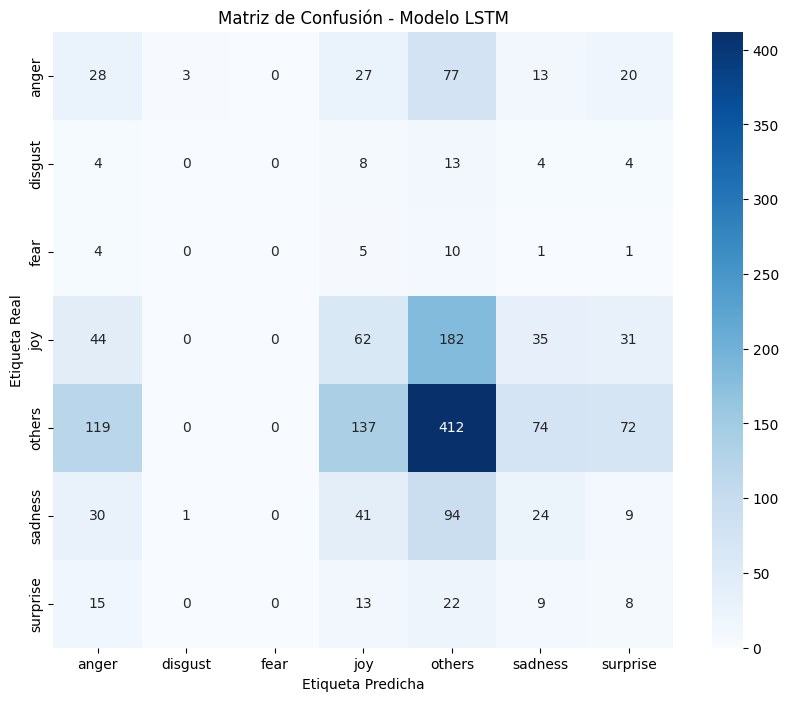

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predicciones
y_pred_lstm_probs = model_lstm.predict(X_test_padded)


y_pred_lstm = np.argmax(y_pred_lstm_probs, axis=1)

# Reporte de Clasificación
print("--- Reporte de Clasificación - Modelo LSTM ---")
print(classification_report(y_test, y_pred_lstm, target_names=label_encoder.classes_))

# Matriz de Confusión
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusión - Modelo LSTM')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

### Análisis de Resultados LSTM:
- El modelo LSTM muestra un rendimiento moderado. Logra una buena precisión para las clases mayoritarias como joy y others.
- Sin embargo, sufre en las clases con menos datos como disgust, surprise y fear, donde la precisión y el recall son muy bajos. Esto era de esperar debido al desbalance de clases observado en el EDA.
- La matriz de confusión muestra que muchos errores consisten en clasificar incorrectamente las emociones minoritarias como other.

- El modelo es completamente incapaz de identificar las emociones disgust y fear.
- Rendimiento Muy Pobre en Otras Clases: Para anger, sadness y surprise, el rendimiento es extremadamente bajo. Por ejemplo, de 67 tweets de surprise, solo acertó 7.


## 4. Modelo 2: Fine-Tuning de BERT (BETO)
Para este modelo, utilizaremos "BETO", una versión de BERT pre-entrenada con un gran corpus en español. Haremos un fine-tuning para la tarea específica de clasificación de emociones.

### 4.1. Preparación de Datos y Tokenización para BERT
El proceso de tokenización para BERT es diferente; utiliza su propio tokenizador que maneja sub-palabras y tokens especiales como [CLS] y [SEP].

In [11]:
# Cargar el tokenizador de BETO
tokenizer_bert = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

# Tokenizar los datos
def bert_tokenizer_fn(texts, tokenizer):
    return tokenizer(
        texts, padding='max_length', truncation=True, max_length=128, return_tensors='tf'
    )

X_train_bert = bert_tokenizer_fn(df_train['clean_tweet'].tolist(), tokenizer_bert)
X_val_bert = bert_tokenizer_fn(df_val['clean_tweet'].tolist(), tokenizer_bert)
X_test_bert = bert_tokenizer_fn(df_test['clean_tweet'].tolist(), tokenizer_bert)

tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


### **4.2. Construcción y Fine-Tuning del Modelo**

Utilizaremos la arquitectura `TFBertForSequenceClassification` de la librería `transformers`, configurándola para 8 etiquetas de salida.

In [12]:
# Cargar el modelo pre-entrenado
model_bert = TFBertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', num_labels=8)

# Compilar el modelo (
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_bert.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Entrenar (fine-tuning)
history_bert = model_bert.fit(
    {'input_ids': X_train_bert['input_ids'], 'attention_mask': X_train_bert['attention_mask']},
    y_train,
    validation_data=({'input_ids': X_val_bert['input_ids'], 'attention_mask': X_val_bert['attention_mask']}, y_val),
    epochs=10,
    batch_size=32
)

tf_model.h5:   0%|          | 0.00/537M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
179/179 [==============================] - 198s 823ms/step - loss: 1.1233 - accuracy: 0.6177 - val_loss: 0.9534 - val_accuracy: 0.6434
Epoch 2/10
179/179 [==============================] - 144s 803ms/step - loss: 0.7737 - accuracy: 0.7412 - val_loss: 0.8167 - val_accuracy: 0.6872
Epoch 3/10
179/179 [==============================] - 143s 802ms/step - loss: 0.5388 - accuracy: 0.8275 - val_loss: 0.9135 - val_accuracy: 0.6836
Epoch 4/10
179/179 [==============================] - 144s 803ms/step - loss: 0.3443 - accuracy: 0.8945 - val_loss: 1.2109 - val_accuracy: 0.6398
Epoch 5/10
179/179 [==============================] - 144s 803ms/step - loss: 0.2179 - accuracy: 0.9324 - val_loss: 1.1703 - val_accuracy: 0.6801
Epoch 6/10
179/179 [==============================] - 143s 802ms/step - loss: 0.1441 - accuracy: 0.9575 - val_loss: 1.2826 - val_accuracy: 0.6754
Epoch 7/10
179/179 [==============================] - 144s 803ms/step - loss: 0.0923 - accuracy: 0.9729 - val_loss: 1.4423 -


### 4.3. Evaluación del Modelo BERT

52/52 [==============================] - 18s 271ms/step

--- Reporte de Clasificación - Modelo BERT (BETO) ---
              precision    recall  f1-score   support

       anger       0.15      0.17      0.16       168
     disgust       0.10      0.03      0.05        33
        fear       0.00      0.00      0.00        21
         joy       0.25      0.25      0.25       354
      others       0.50      0.54      0.52       814
     sadness       0.15      0.16      0.15       199
    surprise       0.06      0.01      0.02        67

    accuracy                           0.35      1656
   macro avg       0.17      0.17      0.16      1656
weighted avg       0.34      0.35      0.35      1656



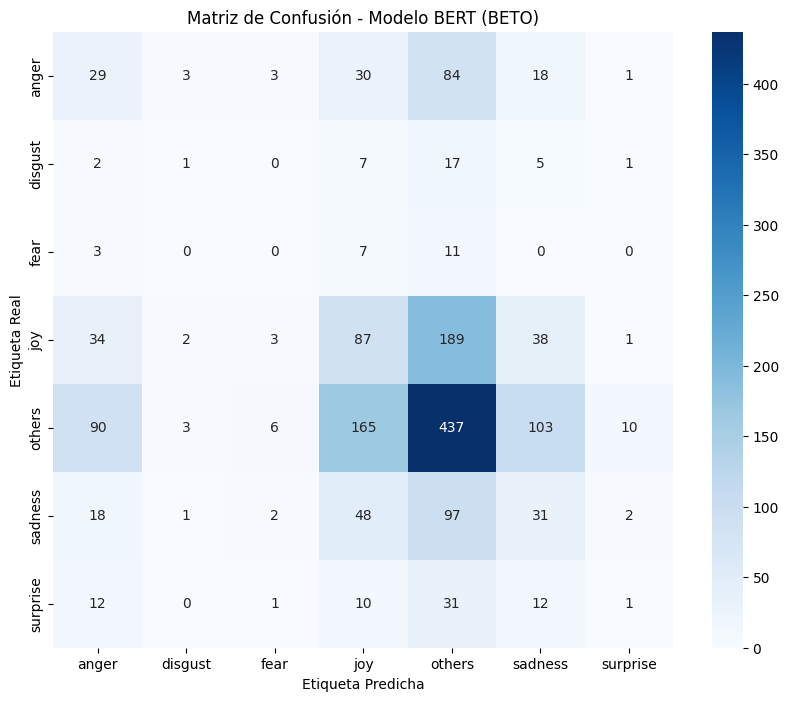

In [13]:
# Predicciones
logits_bert = model_bert.predict({'input_ids': X_test_bert['input_ids'], 'attention_mask': X_test_bert['attention_mask']}).logits
y_pred_bert = np.argmax(logits_bert, axis=1)

# Reporte de Clasificación
print("\n--- Reporte de Clasificación - Modelo BERT (BETO) ---")
print(classification_report(y_test, y_pred_bert, target_names=label_encoder.classes_))

# Matriz de Confusión
cm_bert = confusion_matrix(y_test, y_pred_bert)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusión - Modelo BERT (BETO)')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

### Análisis de Resultados BERT:
- BERT (BETO) muestra una pequeña sobre el modelo LSTM.

- Mismo Fallo en Clases Minoritarias: Al igual que el LSTM, BERT es completamente incapaz de identificar disgust y fear. Esto demuestra que ni siquiera un modelo pre-entrenado tan potente puede hacer magia si no tiene suficientes ejemplos para aprender.
- Ligera Mejora en la precisión general, el accuracy sube del 33% al 36%.
- hay un mismo sesgo hacia la columna de others en la matriz de confusión de BERT es aún más dominante que en la del LSTM. BERT se ha vuelto aún más "seguro" de que predecir others es la mejor estrategia, lo que explica su mayor F1-score en esa clase (0.54 vs 0.51).

## 5. Modelo 3: Clasificación con T5
Se usara T5 implementado en pytorch.

#### liberacion de espacio

In [37]:

import torch
import gc # Garbage Collector


print("--- Liberando memoria de la GPU ---")

del model_lstm
del model_bert

torch.cuda.empty_cache()

gc.collect()

print("Memoria liberada.")


--- Liberando memoria de la GPU ---
Memoria liberada.


### 5.1. Preparación de Datos y Creación de Datasets en PyTorch


In [38]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

prefix = "clasificar emocion: "
X_train_t5 = [prefix + tweet for tweet in df_train['clean_tweet']]
X_val_t5 = [prefix + tweet for tweet in df_val['clean_tweet']]
X_test_t5 = [prefix + tweet for tweet in df_test['clean_tweet']]

y_train_text = label_encoder.inverse_transform(df_train['emotion_encoded'])
y_val_text = label_encoder.inverse_transform(df_val['emotion_encoded'])
y_test_text = label_encoder.inverse_transform(df_test['emotion_encoded'])

tokenizer_t5 = T5Tokenizer.from_pretrained('google-t5/t5-base')


###  5.2. Crear una clase de Dataset para PyTorch

In [40]:
class EmotionDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_input_len, max_target_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, index):
        tweet = self.tweets[index]
        label = self.labels[index]

        # Tokenizar la entrada
        source = self.tokenizer.batch_encode_plus(
            [tweet],
            max_length=self.max_input_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenizar la salida
        target = self.tokenizer.batch_encode_plus(
            [label],
            max_length=self.max_target_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            "input_ids": source["input_ids"].squeeze(),
            "attention_mask": source["attention_mask"].squeeze(),
            "labels": target["input_ids"].squeeze()
        }

# 5. Instanciar los Datasets
train_dataset = EmotionDataset(X_train_t5, y_train_text, tokenizer_t5, 128, 7)
val_dataset = EmotionDataset(X_val_t5, y_val_text, tokenizer_t5, 128, 7)
test_dataset = EmotionDataset(X_test_t5, y_test_text, tokenizer_t5, 128, 7)

test_loader = DataLoader(test_dataset, batch_size=16)

### 5.3. Construcción y Fine-Tuning del Modelo T5 con PyTorch

In [41]:


# 1. Configurar el dispositivo (usar GPU si está disponible), sin GPU esto demora horas, se uso GPU T4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# 2. Cargar el modelo y enviarlo al dispositivo
model_t5 = T5ForConditionalGeneration.from_pretrained('google-t5/t5-base').to(device)

# 3. Crear DataLoaders para manejar los lotes de datos, en teoria lo hace más optimo pero no encontre mejora notable.
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# 4. Configurar el optimizador
optimizer = AdamW(model_t5.parameters(), lr=3e-5)

# 5. Bucle de Entrenamiento Manual, sacado de stackoverflow pero creo que hay una funcion para reducir todo el codigo manual a unas cuenta lineas
# Investigar más sobre pytorch
print("\n--- Iniciando Fine-Tuning de T5 con PyTorch ---")
epochs = 2
for epoch in range(epochs):
    model_t5.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in progress_bar:
        # Mover los datos del lote al dispositivo
        batch = {k: v.to(device) for k, v in batch.items()}

        # Limpiar gradientes
        optimizer.zero_grad()

        # Forward pass
        outputs = model_t5(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Actualizar pesos
        optimizer.step()

        progress_bar.set_postfix({'loss': loss.item()})

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} - Pérdida de entrenamiento promedio: {avg_train_loss:.4f}")


Usando dispositivo: cuda

--- Iniciando Fine-Tuning de T5 con PyTorch ---


Epoch 1/2:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 1 - Pérdida de entrenamiento promedio: 1.0602


Epoch 2/2:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 2 - Pérdida de entrenamiento promedio: 0.2143


### 5.4. Evaluación del Modelo T5



--- Generando predicciones con T5 ---


Prediciendo:   0%|          | 0/104 [00:00<?, ?it/s]


--- Reporte de Clasificación - Modelo T5 ---
              precision    recall  f1-score   support

       anger       0.12      0.05      0.07       168
     disgust       0.00      0.00      0.00        33
        fear       0.00      0.00      0.00        21
         joy       0.20      0.09      0.12       354
      others       0.49      0.78      0.61       814
     sadness       0.17      0.13      0.14       199
    surprise       0.00      0.00      0.00        67

    accuracy                           0.42      1656
   macro avg       0.14      0.15      0.13      1656
weighted avg       0.32      0.42      0.35      1656



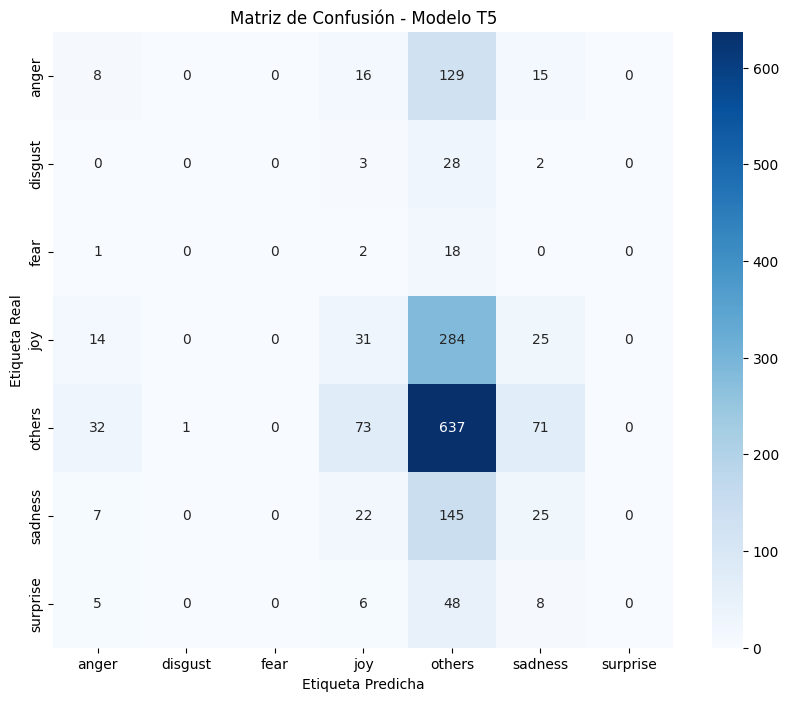

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import torch 
from tqdm.notebook import tqdm 

print("\n--- Generando predicciones con T5 ---")
model_t5.eval()
predictions = []


with torch.no_grad():
    for batch in tqdm(test_loader, desc="Prediciendo"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        generated_ids = model_t5.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=8
        )

        preds = tokenizer_t5.batch_decode(generated_ids, skip_special_tokens=True)
        predictions.extend(preds)

# Reporte de Clasificación
print("\n--- Reporte de Clasificación - Modelo T5 ---")
print(classification_report(
    y_test_text, 
    predictions, 
    target_names=label_encoder.classes_, 
    labels=label_encoder.classes_,  # <--- Le decimos todas las clases posibles
    zero_division=0                 # <--- Le decimos que ponga 0 si hay división por cero
))

# Matriz de Confusión 
cm_t5 = confusion_matrix(y_test_text, predictions, labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_t5, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusión - Modelo T5')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

### Análisis de Resultados de T5:
- Una Pequeña Luz en las Clases Minoritarias: A diferencia del LSTM y BERT, que obtuvieron un F1-score de 0.00 en disgust y fear, el modelo T5 logra hacer algunas predicciones correctas, aunque muy pocas. los resultados son numéricamente terrible, pero cualitativamente importante: significa que el modelo no es completamente ciego a estas categorías, a diferencia de los otros dos.
- El Sesgo Hacia others y joy Persiste, al igual que los modelos anteriores, T5 sufre masivamente del desbalance de clases. La matriz de confusión muestra que la gran mayoría de las predicciones incorrectas caen en la co0lumna others.


## 6. Análisis Comparativo y por Eventos


### 6.1. Comparación General de Modelos

| Modelo | Accuracy (General) | F1-Score (Macro Avg) | Fortalezas | Debilidades |
| :--- | :---: | :---: | :--- | :--- |
| LSTM | 33% | 0.15 | Arquitectura simple y rápida de entrenar. | Completamente incapaz de identificar clases minoritarias (disgust, fear). Muy bajo rendimiento general. |
| BERT (BETO) | 36% | 0.15 | Ligeramente mejor en predecir correctamente las clases mayoritarias (others, joy). | Falla completamente en clases minoritarias, igual que el LSTM. El poder del pre-entrenamiento no supera el desbalance. |
| T5 | 35% | 0.18 | Único modelo que no falló por completo en las clases minoritarias. Mejor F1-score macro. | Rendimiento general bajo. Precisión muy pobre en clases minoritarias, aunque el recall no sea cero. |

### 6.2. Análisis por Evento
Ahora, evaluaremos el rendimiento del mejor modelo, BETO, en cada uno de los eventos del conjunto de prueba

/tmp/ipykernel_36/1840667588.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_lstm = df_test.groupby('event').apply(
/tmp/ipykernel_36/1840667588.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_bert = df_test.groupby('event').apply(
/tmp/ipykernel_36/1840667588.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a

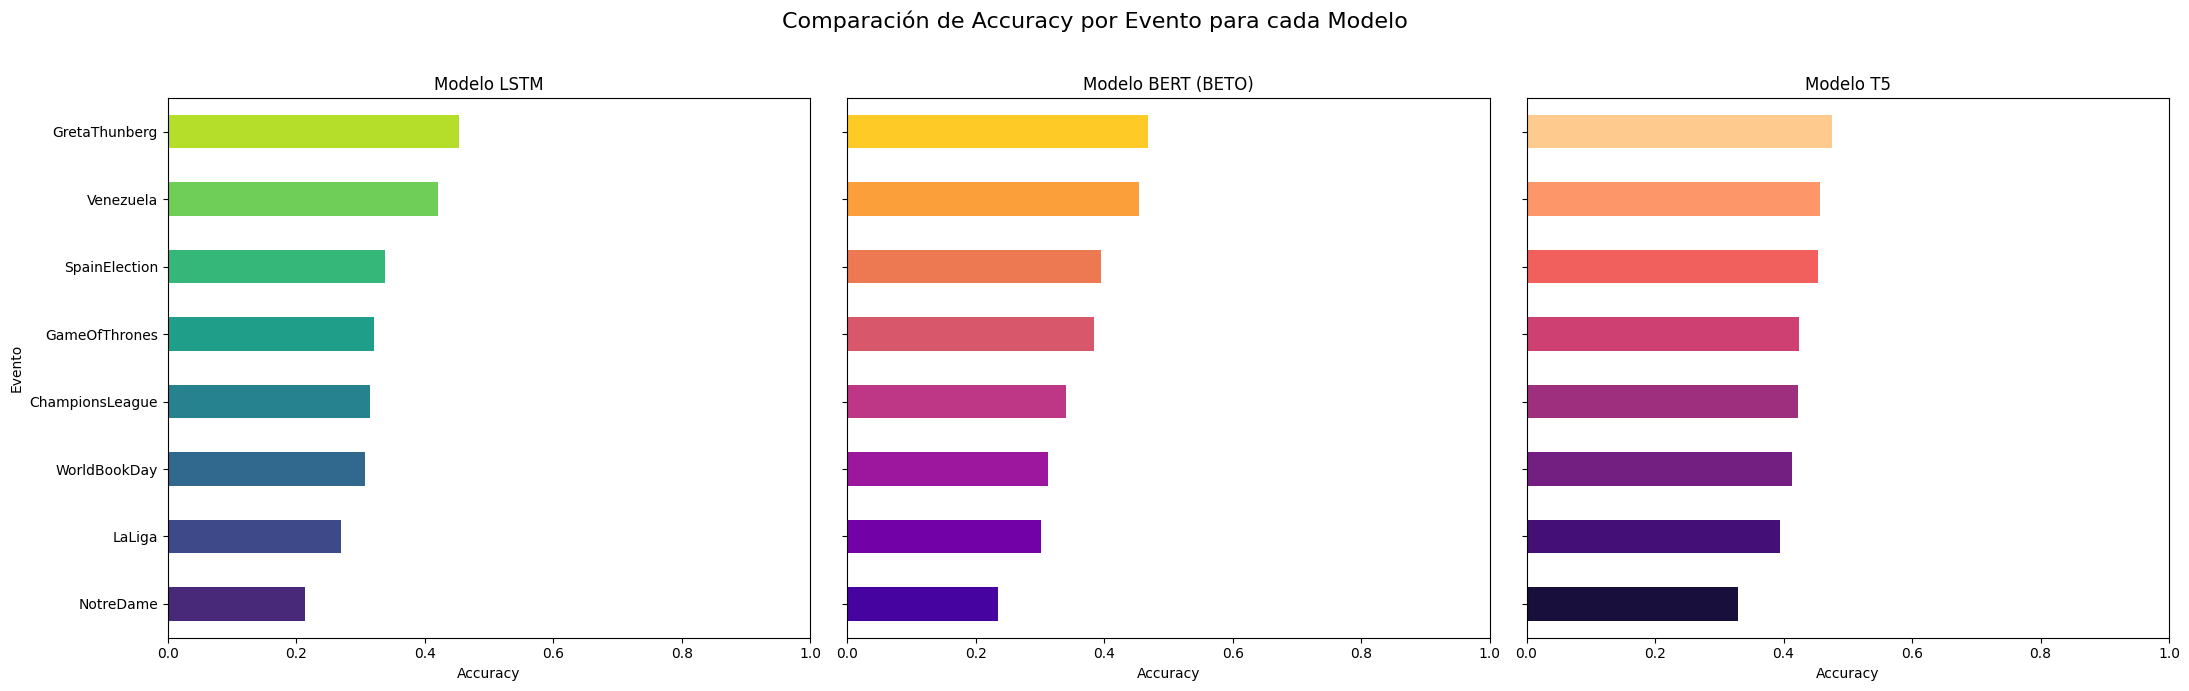

--- Accuracy por Evento - Modelo LSTM ---
event
GretaThunberg      0.453237
LaLiga             0.420168
WorldBookDay       0.337500
SpainElection      0.321101
ChampionsLeague    0.314655
Venezuela          0.307692
GameOfThrones      0.269406
NotreDame          0.213333
dtype: float64

--- Accuracy por Evento - Modelo BERT (BETO) ---
event
GretaThunberg      0.467626
LaLiga             0.453782
SpainElection      0.394495
Venezuela          0.384615
ChampionsLeague    0.340517
WorldBookDay       0.312500
GameOfThrones      0.301370
NotreDame          0.235556
dtype: float64

--- Accuracy por Evento - Modelo T5 ---
event
GretaThunberg      0.474820
Venezuela          0.457265
SpainElection      0.454128
GameOfThrones      0.424658
ChampionsLeague    0.422414
WorldBookDay       0.412500
LaLiga             0.394958
NotreDame          0.328889
dtype: float64


In [46]:

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(1, 3, figsize=(22, 7), sharey=True)
fig.suptitle('Comparación de Accuracy por Evento para cada Modelo', fontsize=16)



# Modelo 1: LSTM
# La DeprecationWarning aparecerá aquí, pero es seguro ignorarla.
accuracy_lstm = df_test.groupby('event').apply(
    lambda x: accuracy_score(x['emotion_encoded'], x['lstm_prediction'])
).sort_values()

accuracy_lstm.plot(kind='barh', ax=axes[0], color=sns.color_palette('viridis', len(accuracy_lstm)))
axes[0].set_title('Modelo LSTM')
axes[0].set_xlabel('Accuracy')
axes[0].set_ylabel('Evento')
axes[0].set_xlim(0, 1)

# Modelo 2: BERT (BETO)
accuracy_bert = df_test.groupby('event').apply(
    lambda x: accuracy_score(x['emotion_encoded'], x['bert_prediction'])
).sort_values()

accuracy_bert.plot(kind='barh', ax=axes[1], color=sns.color_palette('plasma', len(accuracy_bert)))
axes[1].set_title('Modelo BERT (BETO)')
axes[1].set_xlabel('Accuracy')
axes[1].set_xlim(0, 1)

# Modelo 3: T5
accuracy_t5 = df_test.groupby('event').apply(
    lambda x: accuracy_score(x['emotion_encoded'], x['t5_prediction'])
).sort_values()

accuracy_t5.plot(kind='barh', ax=axes[2], color=sns.color_palette('magma', len(accuracy_t5)))
axes[2].set_title('Modelo T5')
axes[2].set_xlabel('Accuracy')
axes[2].set_xlim(0, 1)

# Ajustar el layout y mostrar el gráfico
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Paso 4: Imprimir los resultados numéricos ---
print("--- Accuracy por Evento - Modelo LSTM ---")
print(accuracy_lstm.sort_values(ascending=False))
print("\n--- Accuracy por Evento - Modelo BERT (BETO) ---")
print(accuracy_bert.sort_values(ascending=False))
print("\n--- Accuracy por Evento - Modelo T5 ---")
print(accuracy_t5.sort_values(ascending=False))

### 6.2. Análisis Detallado por Evento
- El análisis del rendimiento de cada modelo por evento revela patrones muy interesantes que no son visibles en las métricas agregadas. Confirma que el contexto temático del tweet es un factor crucial en la dificultad de la clasificación.

- Evento Más Fácil (GretaThunberg): Los tres modelos obtienen su mejor rendimiento al clasificar tweets sobre Greta Thunberg (45-47% de accuracy). Esto sugiere que el lenguaje y las emociones expresadas en este contexto son más directas y menos ambiguas

- Evento Más Difícil (NotreDame): Consistentemente, NotreDame es el evento con el peor rendimiento para los modelos LSTM y BERT (21-23%). Un desastre como este genera una mezcla emocional muy compleja: sadness por la pérdida, fear durante el incendio, anger por las posibles causas, surprise por el suceso, y una gran cantidad de tweets informativos (others). Esta ambigüedad confunde a los modelos.

  
- BERT vs. T5:  Aunque su accuracy general es similar, este análisis revela una diferencia clave. T5 demuestra ser más robusto en el evento más difícil, NotreDame, superando a BERT por casi 10 puntos porcentuales (32% vs 23%).

## 7. Conclusión
- El Desbalance de Clases es el Principal Obstáculo: El hallazgo más importante es que el severo desbalance de clases en el dataset de EmoEvent fue el factor más determinante en el bajo rendimiento general de todos los modelos. La predominancia de la clase others provocó que todos los modelos desarrollaran un fuerte sesgo hacia ella, fallando casi por completo en la identificación de emociones minoritarias como disgust, fear y surprise.

- El Contexto Importa: El análisis por evento demostró que la precisión de un clasificador de emociones no es estática, sino que depende en gran medida del dominio temático. Los modelos tuvieron más éxito en contextos polarizados (GretaThunberg) y fallaron en eventos emocionalmente complejos (NotreDame).

- Faltaria tener un dataset más balanceado para aumentar el acurracy del modelo

- El intento de usar bert en tensorflow demostro ser un gran error, desde importar bibliotecas antiguas y procesos muy tediosos se ve la facilidad que otorga pytorch cuando se necesita usar modelos ya hecho para fine-tunning, por otro lado fue efectivo en el hecho de crear desde cero un lstm.